In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

#import nmrglue as ng
import scipy
import scipy.io

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(123)

In [2]:
mod = "PIPNet_2022_10_03_batch_6"
epoch = 200

in_dir = f"../../data/1D/{mod}/"
fig_dir = f"../../figures/1D/{mod}/"

eval_all = True

eval_sel = True
sel_wrs = [40000., 42000., 44000., 46000., 48000.,
           50000., 52000., 54000., 56000., 58000.,
           60000., 62000., 64000., 66000., 68000.,
           70000., 72000., 74000., 76000., 78000.,
           80000., 82000., 84000., 86000., 88000.,
           90000., 92000., 94000., 96000., 98000., 100000.]

ppm_range = [-5., 20.]

compounds = ["ampicillin", "aspala", "flutamide", "histidine",
             "thymol", "tyrosine", "mdma", "molnupiravir"]

exp_dir = "../../data/experimental_spectra/1D/"

peaks = {"ampicillin": [[0.25, 0.7], [1.3, 1.7], [3.5, 4.1], [4.3, 4.7], [4.8, 5.2], [6.1, 6.6], [9.5, 10.5]],
         "aspala": [[0.5, 1.], [1.9, 2.2], [2.3, 3.], [3.7, 4.1], [4.5, 5.], [7., 7.5], [7.7, 8.2], [12.3, 12.8]],
         "flutamide": [[0.7, 1.5], [1.8, 2.2]],
         "histidine": [[2.3, 2.9], [2.8, 3.5], [4.8, 5.2], [7.2, 7.8], [8.6, 9.2], [12, 12.8], [16.7, 17.4]],
         "thymol": [[0.2, 0.7], [0.8, 1.3], [1.3, 1.8], [3, 3.5], [5, 5.7], [5.7, 6.4], [6.7, 7.2], [9, 9.5]],
         "tyrosine": [[2.3, 2.7], [6.4, 6.8], [9.7, 10.2]],
         "mdma": [[0., 1.6]],
         "molnupiravir": [[10.1, 11.2], [8.8, 10.1], [6.3, 7.2], [2.2, 3.0], [0.5, 1.7]]}

int_regions = {"ampicillin": [[12., 8.5], [8.5, 3.], [3., -2.]],
               "aspala": [[15., 10.], [10., 6.], [6., 3.4], [3.4, 1.5], [1.5, 0.]],
               "flutamide": [[11., 9.], [9., 5.], [5., -2.]],
               "histidine": [[20., 15.], [15., 10.5], [10.5, 6.5], [6.5, 4.2], [4.2, -2.]],
               "thymol": [[12., 8.], [8., 4.5], [4.5, 2.7], [2.7, -2]],
               "tyrosine": [[14., 11.], [11., 9.], [9., 6.1], [6.1, 3.5], [3.5, 0.]],
               "mdma": [[13., 8.], [8., 5.], [5., -1.]],
               "molnupiravir": [[12.0, 8.0], [8.0, 2.0], [2.0, -5.]]
              }

iso_dir = "../../data/experimental_spectra/1D/iso/"

iso_res = {"ampicillin": ["4k", "4k", "4k", "4k"],
           "aspala": ["4k", "4k", "4k", "4k", "4k"],
           "flutamide": ["4k", "4k", "4k"],
           "histidine": ["4k", "4k", "4k", "4k", "4k"],
           "thymol": ["4k", "4k", "4k", "4k"],
           "tyrosine": ["4k", "4k", "4k", "4k", "4k"],
           "mdma": ["4k", "4k", "4k", "4k"],
           "molnupiravir": ["4k", "4k", "4k", "4k", "4k", "4k", "4k"]}

iso_parts = {'ampicillin': ['NH3', 'NHAr5', 'Ar6104b', 'Me2'],
             'aspala': ['OH', 'NHNH3', 'CHCH', 'CH2', 'CH3'],
             'flutamide': ['H5b', 'H368b', 'H101112'],
             'histidine': ['H5', 'H7', 'H618', 'H9', 'H342'],
             'thymol': ['H7', 'H321c', 'H4', 'H556'],
             'tyrosine': ['COOH', 'OH', 'NH3H76', 'H5823', 'H3dia'],
             "mdma": ["R1ph_og_divby1456", "R2ph_og_divby1456", "R3ph_og_divby1456", "R4ph_og_divby1456"],
             "molnupiravir": ["R1", "R2", "R3", "R4", "R5", "R6", "R7"]}

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
fdir = fig_dir + "eval_experimental/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [4]:
with open(f"{in_dir}model_pars.pk", "rb") as F:
    model_pars = pk.load(F)
model_pars["noise"] = 0.

with open(f"{in_dir}data_pars.pk", "rb") as F:
    data_pars = pk.load(F)

In [5]:
net = model.ConvLSTMEnsemble(**model_pars)
net.load_state_dict(torch.load(in_dir + f"epoch_{epoch}_network", map_location=torch.device(device)))
net = net.eval()

In [6]:
def plot_lw_evolution(ws, lws, pks, c0=np.array([0., 1., 1.]), dc=np.array([0., -1., 0.]), show=False, save=None):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = lws.shape[0]-1
    if n <= 0:
        n = 1
    
    for i, lw in enumerate(lws):
        ax.plot(ws, lw, color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Linewidth [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_lws.pdf")
        
    plt.close()
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    for i, pk in enumerate(pks):
        ax.plot(ws, pk-pk[-1], color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Peak deviation [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_pks.pdf")
        
    plt.close()
    
    return

In [7]:
all_exp_int = []

all_pip_lws = []
all_pip_pks = []
all_pip_int = []

all_all_lws = []
all_all_pks = []
all_all_int = []

all_sel_lws = []
all_sel_pks = []
all_sel_int = []

for compound in compounds:
    
    print(compound)
    
    ppm, hz, ws, xr, xi = utils.extract_1d_dataset(f"{exp_dir}{compound}/", 1, 1000)
    trg_ppm, trg_pred, trg_std = utils.extract_1d_pip(iso_dir, compound, iso_parts[compound], iso_res[compound])
    trg_max = np.max(trg_pred)
    trg_pred /= trg_max
    trg_std /= trg_max
    
    pip_lws, pip_pks = utils.extract_linewidths(trg_ppm, trg_pred, peaks[compound])
    all_pip_lws.append(pip_lws)
    all_pip_pks.append(pip_pks)
    all_pip_int.append(utils.get_relative_integrals(trg_ppm, trg_pred, int_regions[compound]))
    
    inds = np.where(np.logical_and(ppm >= ppm_range[0], ppm <= ppm_range[1]))[0]
    ppm = ppm[inds]
    hz = hz[inds]
    xr = xr[:, inds]
    xi = xi[:, inds]
    
    all_exp_int.append(utils.get_relative_integrals(ppm, xr[-1], int_regions[compound]))
    
    X = utils.prepare_input(xr, ws, data_pars, xi=xi, xmax=0.5)
    
    if eval_all:
        
        with torch.no_grad():
            y_pred, y_std, _ = net(X)
        y_pred = y_pred.numpy()
        y_std = y_std.numpy()
        
        utils.plot_iso_prediction(
            X[0],
            y_pred[0],
            y_std[0],
            y_trg = trg_pred,
            y_trg_std = trg_std,
            trg_scale=0.1,
            X_offset=0.2,
            pred_offset=0.1,
            xvals=ppm,
            x_trg=trg_ppm,
            wr_factor=data_pars["wr_norm_factor"],
            xinv=True,
            ylim=[-0.1, 0.8],
            all_steps=True,
            show=False,
            save=f"{fdir}all_wr_{compound}.pdf"
        )
        
        
        these_lws = []
        these_pks = []
        for i in range(y_pred.shape[1]):
            all_lws, all_pks = utils.extract_linewidths(ppm, y_pred[0, i], peaks[compound])
            these_lws.append(all_lws)
            these_pks.append(all_pks)
        
        all_all_lws.append(np.array(all_lws))
        all_all_pks.append(np.array(all_pks))
        all_all_int.append(utils.get_relative_integrals(ppm, y_pred[0, -1], int_regions[compound]))
        
        plot_lw_evolution(ws[-y_pred.shape[1]:], np.array(these_lws).T, np.array(these_pks).T, save=f"{fdir}linewidth_evolution_{compound}_all")
    
    if eval_sel:
        
        wr_inds = [np.argmin(np.abs(ws - w)) for w in sel_wrs]
        X = X[:, wr_inds]
        
        with torch.no_grad():
            y_pred, y_std, _ = net(X)
        y_pred = y_pred.numpy()
        y_std = y_std.numpy()
        
        utils.plot_iso_prediction(
            X[0],
            y_pred[0],
            y_std[0],
            y_trg = trg_pred,
            y_trg_std = trg_std,
            trg_scale=0.1,
            X_offset=0.2,
            pred_offset=0.1,
            xvals=ppm,
            x_trg=trg_ppm,
            wr_factor=data_pars["wr_norm_factor"],
            xinv=True,
            ylim=[-0.1, 0.8],
            all_steps=True,
            show=False,
            save=f"{fdir}sel_wr_{compound}.pdf"
        )
        
        these_lws = []
        these_pks = []
        for i in range(y_pred.shape[1]):
            sel_lws, sel_pks = utils.extract_linewidths(ppm, y_pred[0, i], peaks[compound])
            these_lws.append(sel_lws)
            these_pks.append(sel_pks)
            
        all_sel_lws.append(np.array(sel_lws))
        all_sel_pks.append(np.array(sel_pks))
        all_sel_int.append(utils.get_relative_integrals(ppm, y_pred[0, -1], int_regions[compound]))
        
        plot_lw_evolution(ws[-y_pred.shape[1]:], np.array(these_lws).T, np.array(these_pks).T, save=f"{fdir}linewidth_evolution_{compound}_sel")

ampicillin
aspala
flutamide
histidine
thymol
tyrosine
mdma
molnupiravir


In [8]:
def plot_lw(all_lws_fit, all_lws_net, all_pks_fit, all_pks_net, compounds, save):

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net, s=10, linewidths=0.)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net, s=10, linewidths=0.)

    ax1.set_xlabel("PIP linewidth [ppm]")
    ax1.set_ylabel("PIPNet linewidth [ppm]")
    ax2.set_xlabel("PIP peak [ppm]")
    ax2.set_ylabel("PIPNet peak [ppm]")

    ax2.legend(compounds, bbox_to_anchor=(1., 1.))

    fig.tight_layout()

    plt.savefig(f"{save}_preds.pdf")
    plt.close()

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net - lws_fit, s=10, linewidths=0.)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net - pks_fit, s=10, linewidths=0.)

    ax1.set_xlabel("PIP linewidth [ppm]")
    ax1.set_ylabel("linewidth difference [ppm]")
    ax2.set_xlabel("PIP peak [ppm]")
    ax2.set_ylabel("peak difference [ppm]")

    lw_mae = np.mean(np.abs(np.concatenate(all_lws_fit) - np.concatenate(all_lws_net)))
    pk_mae = np.mean(np.abs(np.concatenate(all_pks_fit) - np.concatenate(all_pks_net)))

    ax1.title.set_text(f"MAE = {lw_mae:.2f} ppm")
    ax2.title.set_text(f"MAE = {pk_mae:.2f} ppm")

    ax2.legend(compounds, bbox_to_anchor=(1., 1.))

    fig.tight_layout()

    plt.savefig(f"{save}_preds_diff.pdf")
    plt.close()
    
    return

In [9]:
plot_lw(all_pip_lws, all_all_lws, all_pip_pks, all_all_pks, compounds, f"{fdir}linewidths_all")
plot_lw(all_pip_lws, all_sel_lws, all_pip_pks, all_sel_pks, compounds, f"{fdir}linewidths_sel")

In [10]:
def plot_integrals(all_X_int, all_y_int, compounds, int_regions, w=0.2, label_h=0.1, show=True, save=None):
    
    # Compound separations
    sep = []
    mid = []
    labels = []
    bounds = []
    i = 0
    for k in compounds:
        if k in int_regions:
            l = len(int_regions[k])
            labels.append(k)
            sep.append(i+l - 0.5)
            mid.append(i + (l / 2) - 0.5)
            i += l
            bounds.append([r[1] for r in int_regions[k][:-1]])
    sep = sep[:-1]
    
    err_avg = []
    err_std = []
    for xint, yint in zip(all_X_int, all_y_int):
        err_avg.append(np.mean(np.abs(xint-yint)))
        err_std.append(np.std(np.abs(xint-yint)))
    
    x = np.array(range(i))
    
    xint = np.concatenate(all_X_int)
    yint = np.concatenate(all_y_int)
    
    M = max(np.max(xint), np.max(yint)) * 1.1
    
    fig = plt.figure(figsize=(i*0.4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.bar(x-(w/2), xint, width=w)
    ax.bar(x+(w/2), yint, width=w)
    
    ax.legend(["100 kHz MAS", "PIPNet"], bbox_to_anchor=(0.,0.9), loc="upper left")
    
    for s in sep:
        ax.plot([s, s], [0., M], "k")
    
    lx = 0.5
    for b in bounds:
        for bi in b:
            ax.plot([lx, lx], [0, label_h], "k:")
            ax.text(lx, label_h, f" {bi} ppm", rotation=90, ha="center", va="bottom", size=8)
            lx += 1
        lx += 1
    
    for em, es, m in zip(err_avg, err_std, mid):
        ax.text(m, M*0.99, f"mae: {em:.3f}\n±{es:.3f}", ha="center", va="top", size=8)
    
    ax.set_xticks(mid)
    ax.set_xticklabels(labels)
    
    ax.set_ylabel("Relative integral")
    
    ax.set_ylim(0., M)
    ax.set_xlim(-0.5, i-0.5)
    
    if save is not None:
        plt.savefig(save)
    
    if show:
        plt.show()
    
    plt.close()
    
    return

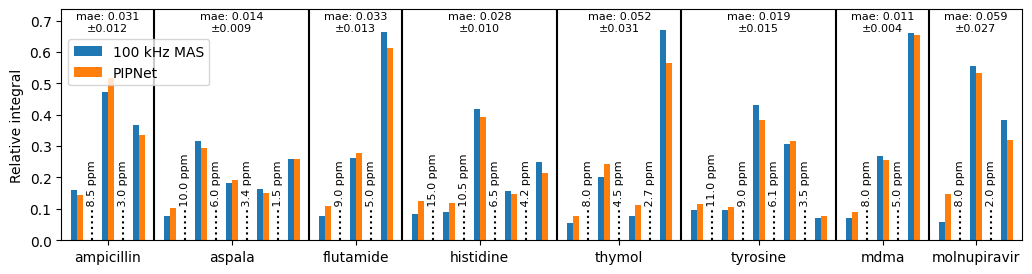

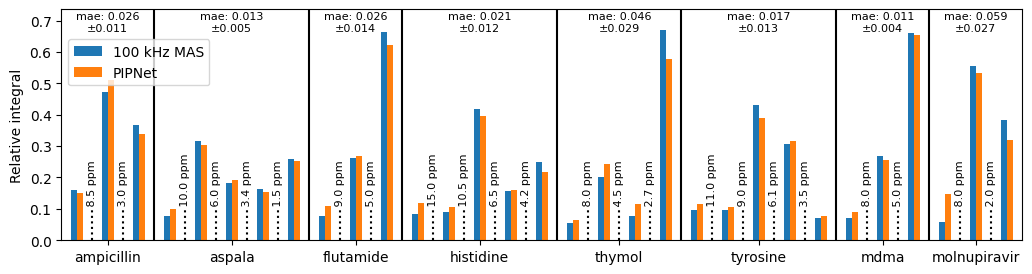

In [11]:
plot_integrals(all_exp_int, all_all_int, compounds, int_regions, save=f"{fdir}integrals_all.pdf")
plot_integrals(all_exp_int, all_sel_int, compounds, int_regions, save=f"{fdir}integrals_sel.pdf")